In [1]:
from wordcloud import WordCloud

class Topic:
    def __init__(self, cluster):
        self.cluster = cluster
        self.sentences = []
        self.sentences_dump = ""
        self.words = []
        self.wordcloud = WordCloud()
        self.texts = []
        self.sorted_terms = []
        self.coherence = 0.0
        
class TopicModel:
    def __init__(self):
        self.sentences = []
        self.vocabulary = []     
        self.topics = []
        self.topics_coherence = 0.0
        
model = TopicModel()

# Step 1: Sentences Modeling

In [2]:
import os.path

DATASET = 'clicr'
DATASET_PATH = '../datasets/'+DATASET+'/cases-titles.txt'

BERT_MODEL = 'fagner/envoy'

OUTPUT_PATH = 'output/'
if not os.path.exists(OUTPUT_PATH): os.mkdir(OUTPUT_PATH)
OUTPUT_PATH += DATASET + '/'
if not os.path.exists(OUTPUT_PATH): os.mkdir(OUTPUT_PATH)
OUTPUT_PATH += BERT_MODEL + '/'
if not os.path.exists(OUTPUT_PATH): os.makedirs(OUTPUT_PATH, exist_ok=True)

In [ ]:
from sentence_transformers import SentenceTransformer

with open(DATASET_PATH) as f:
    model.sentences = f.readlines()
language_model = SentenceTransformer(BERT_MODEL)
embeddings = language_model.encode(model.sentences)

<Figure size 640x480 with 0 Axes>

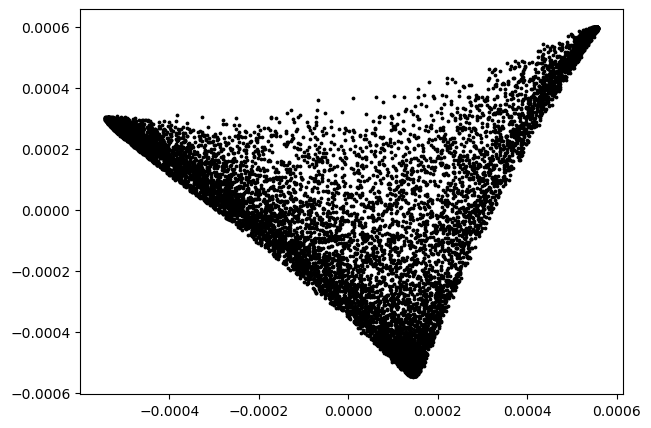

In [4]:
from matplotlib import pyplot as plt 
from sklearn import manifold

X_2d = manifold.SpectralEmbedding(n_components=2).fit_transform(embeddings)
 
x = X_2d[:,0]
y = X_2d[:,1]

plt.clf()
plt.figure(figsize=(7, 5))
plt.scatter(x, y, color='black', s=3)
plt.savefig(OUTPUT_PATH + 'sentence-embeddings-'+str(BERT_MODEL).replace('/','').replace('.','') + '.jpg', bbox_inches='tight')
# plt.savefig(OUTPUT_PATH + 'sentence-embeddings-'+str(MODEL).replace('/','').replace('.','') + '.eps', bbox_inches='tight', format='eps')

# Step 2: Sentences Aggregation

In [5]:
DISTANCE_THRESHOLD = 150

In [6]:
from sklearn.cluster import AgglomerativeClustering

clustering_model = AgglomerativeClustering(linkage='ward', distance_threshold=DISTANCE_THRESHOLD, n_clusters=None)
clustering_model = clustering_model.fit(embeddings)
n_clusters = clustering_model.n_clusters_

print('Distance Threshold: ', DISTANCE_THRESHOLD)
print('Resulting Clusters:',  n_clusters)

Distance Threshold:  150
Resulting Clusters: 7


<Figure size 640x480 with 0 Axes>

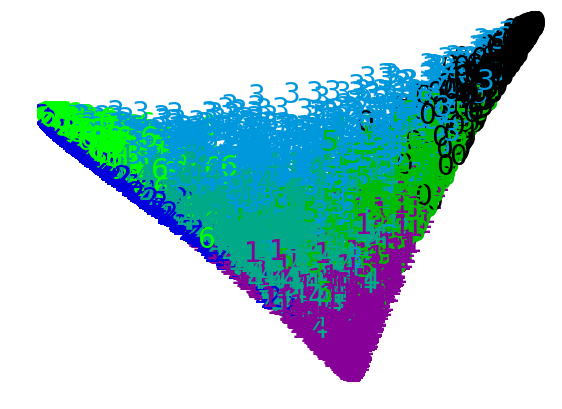

In [7]:
plt.clf()
plt.figure(figsize=(7, 5))

# plt.scatter(x, y, color=plt.cm.nipy_spectral(clustering_model.labels_[i] / 10.), s=1)
plt.scatter(x, y, color='w', s=1)


# plt.cm.nipy_spectral(clustering_model.labels_[i] / 10.)

for i, sentence in enumerate(model.sentences):

    # plt.annotate(clustering_model.labels_[i], (x[i], y[i]), color='black', fontsize=8)
    # plt.annotate('°', (x[i], y[i]), color=plt.cm.nipy_spectral(clustering_model.labels_[i] / 10.), fontsize=20)

    plt.annotate(clustering_model.labels_[i], (x[i], y[i]), color=plt.cm.nipy_spectral(clustering_model.labels_[i] / 10.), fontsize=20)
    

if not os.path.exists(OUTPUT_PATH + str(n_clusters) + 'topics'): os.mkdir(OUTPUT_PATH + str(n_clusters) + 'topics')

plt.axis("off")
# plt.savefig(OUTPUT_PATH + str(n_clusters) + 'topics/clusters-'+str(MODEL).replace('/','').replace('.','') + '.eps', bbox_inches='tight', format='eps')
plt.savefig(OUTPUT_PATH + str(n_clusters) + 'topics/clusters-'+str(BERT_MODEL).replace('/','').replace('.','') + '.png', bbox_inches='tight', transparent=True)



## Topic Hierarchy

<Figure size 640x480 with 0 Axes>

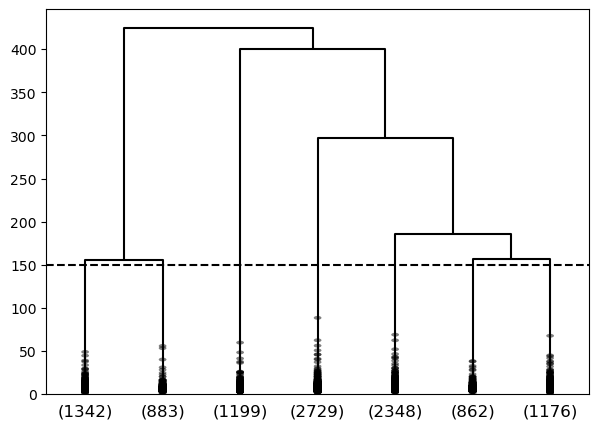

In [8]:
from scipy.cluster.hierarchy import dendrogram
import numpy as np

plt.clf()
plt.figure(figsize=(7,5))

counts = np.zeros(clustering_model.children_.shape[0])
n_samples = len(clustering_model.labels_)

for i, merge in enumerate(clustering_model.children_):
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            current_count += 1 
        else: current_count += counts[child_idx - n_samples]
    counts[i] = current_count

linkage_matrix = np.column_stack([clustering_model.children_, clustering_model.distances_, counts]).astype(float)

r = dendrogram(linkage_matrix, truncate_mode='lastp', p=n_clusters, color_threshold=0, show_contracted=True, above_threshold_color='black')
plt.axhline(c='black', linestyle='--', y=DISTANCE_THRESHOLD) 

# plt.savefig(OUTPUT_PATH + 'dendrograma-'+str(MODEL).replace('/','').replace('.','')+'.eps', bbox_inches='tight')
plt.savefig(OUTPUT_PATH + 'dendrograma-'+str(BERT_MODEL).replace('/','').replace('.','')+'.png', bbox_inches='tight')

# Step 3: Representing Topics

In [9]:
MAX_DF = 0.99
TOP_WORDS = 10

In [10]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

model.topics = [Topic(i) for i in range(n_clusters)]
for i in range(len(model.sentences)):
    cluster_index = clustering_model.labels_[i]
    model.topics[cluster_index].sentences.append(model.sentences[i])
    model.topics[cluster_index].sentences_dump += model.sentences[i] + " "

tfidf_model = TfidfVectorizer(max_df=MAX_DF)
c_tfidf = tfidf_model.fit_transform([topic.sentences_dump for topic in model.topics])
tfidf_matrix = c_tfidf.toarray()

terms = tfidf_model.get_feature_names_out()
model.vocabulary = terms

terms_by_topic = tfidf_model.inverse_transform(c_tfidf)
        
for i, topic in enumerate(model.topics):
    sorted_term_indexes = np.argsort(-1*tfidf_matrix[topic.cluster])
    topic.sorted_terms = [terms[j] for j in sorted_term_indexes]   
    
    # topic.sorted_terms = sorted_terms
    topic.words = terms_by_topic[i]
    
    dense = c_tfidf[topic.cluster].todense()
    lst1 = dense.tolist()
    tfidf_data_frame = pd.DataFrame(lst1, columns=terms)

    topic.wordcloud = WordCloud(mode='RGBA', background_color="white", max_words=TOP_WORDS, color_func=lambda *args, **kwargs: "black").generate_from_frequencies(tfidf_data_frame.T.sum(axis=1))

<Figure size 640x480 with 0 Axes>

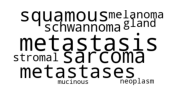

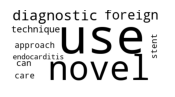

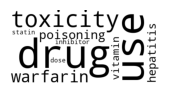

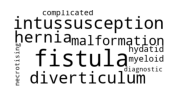

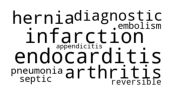

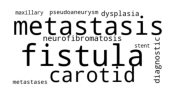

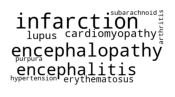

In [14]:
from matplotlib import pyplot as plt 

plt.clf()

for topic in model.topics:
    plt.figure(figsize=(2, 2))
    # plt.figure(figsize=(2.5, 2.5))

    plt.imshow(topic.wordcloud)
    plt.axis("off")
    # plt.show()

    if not os.path.exists(OUTPUT_PATH + str(n_clusters) + 'topics'): os.mkdir(OUTPUT_PATH + str(n_clusters) + 'topics')

    plt.savefig(OUTPUT_PATH + str(n_clusters) + 'topics/wordcloud'+str(topic.cluster)+'.png', transparent=True, bbox_inches='tight')

# Validation

In [ ]:
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary

dictionary = Dictionary(terms_by_topic)
corpus = [dictionary.doc2bow(t) for t in terms_by_topic]
texts = [[dictionary[word_id] for word_id, freq in c] for c in corpus]

cm = CoherenceModel(topics=[topic.words for topic in model.topics], texts=texts, corpus=corpus, dictionary=dictionary, coherence='c_v',topn=TOP_WORDS)

model.topics_coherence = cm.get_coherence()
model.coherence_per_topic = cm.get_coherence_per_topic()

for i, coherence in enumerate(model.coherence_per_topic):
    model.topics[i].coherence = coherence

print('Total coherence: ', model.topics_coherence)
print('Coherence by topic: ', model.coherence_per_topic)    

In [13]:
with open(OUTPUT_PATH + '/topic-attention-results.txt', "a") as file:
    print('Hyper-parameters: ', file=file) 
    print('Language Model: ' + BERT_MODEL + '\t Distance Threshold: '+str(DISTANCE_THRESHOLD) + '\t Resulting Topics: '+str(n_clusters) + '\t TfIdf Threshold: '+str(MAX_DF) + '\t Top Words: '+str(TOP_WORDS), file=file)   
    print("", file=file)
    for topic in model.topics:
        print('Topic '+str(topic.cluster), file=file)    
        print('Documents length: '+str(len(topic.sentences)), file=file)
        print('Terms length: '+str(len(topic.words)), file=file)

        print('Coherence: '+str(topic.coherence), file=file)
        print('Top Words: '+str(topic.sorted_terms[:10]), file=file)  
        print('', file=file)

    print('Total Coherence: '+str(model.topics_coherence), file=file)  
    print('Total Terms considered: '+str(len(model.vocabulary)), file=file)
    print('----------------------------------------------------------------------------', file=file)  